# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import glob
import dgl
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from rdkit import Chem
from torch.utils.data import Dataset
from script_baseline.Baseline_MG import get_mg_nodes_feat,Get_Baseline_MG_feat
from script_baseline.GCN import GCN1
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

Using backend: pytorch
[16:27:57] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory


# Load Data

In [2]:
data_file = '../data1/data1.csv'
mol_dir = '../data1/data1_sdf_files/'
tmp_df = pd.read_csv(data_file)
labels_ori = tmp_df['Output'].to_list()
labels_ori=np.array(labels_ori)
label_std = (np.array(labels_ori)-np.min(labels_ori))/(np.max(labels_ori)-np.min(labels_ori))

In [3]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

sdf_file=lig_files+add_files+base_files+ar_ha_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [4]:
lig_Graph_name_dict=Get_Baseline_MG_feat(lig_files)

../data1/data1_sdf_files/lig_0.sdf
../data1/data1_sdf_files/lig_1.sdf
../data1/data1_sdf_files/lig_2.sdf
../data1/data1_sdf_files/lig_3.sdf


In [5]:
ar_ha_Graph_name_dict=Get_Baseline_MG_feat(ar_ha_files)

../data1/data1_sdf_files/ar_ha_0.sdf
../data1/data1_sdf_files/ar_ha_1.sdf
../data1/data1_sdf_files/ar_ha_2.sdf
../data1/data1_sdf_files/ar_ha_3.sdf
../data1/data1_sdf_files/ar_ha_4.sdf
../data1/data1_sdf_files/ar_ha_5.sdf
../data1/data1_sdf_files/ar_ha_6.sdf
../data1/data1_sdf_files/ar_ha_7.sdf
../data1/data1_sdf_files/ar_ha_8.sdf
../data1/data1_sdf_files/ar_ha_9.sdf
../data1/data1_sdf_files/ar_ha_10.sdf
../data1/data1_sdf_files/ar_ha_11.sdf
../data1/data1_sdf_files/ar_ha_12.sdf
../data1/data1_sdf_files/ar_ha_13.sdf
../data1/data1_sdf_files/ar_ha_14.sdf


In [6]:
base_Graph_name_dict=Get_Baseline_MG_feat(base_files)

../data1/data1_sdf_files/base_0.sdf
../data1/data1_sdf_files/base_1.sdf
../data1/data1_sdf_files/base_2.sdf


In [7]:
add_Graph_name_dict=Get_Baseline_MG_feat(add_files)

../data1/data1_sdf_files/add_0.sdf
../data1/data1_sdf_files/add_1.sdf
../data1/data1_sdf_files/add_2.sdf
../data1/data1_sdf_files/add_3.sdf
../data1/data1_sdf_files/add_4.sdf
../data1/data1_sdf_files/add_5.sdf
../data1/data1_sdf_files/add_6.sdf
../data1/data1_sdf_files/add_7.sdf
../data1/data1_sdf_files/add_8.sdf
../data1/data1_sdf_files/add_9.sdf
../data1/data1_sdf_files/add_10.sdf
../data1/data1_sdf_files/add_11.sdf
../data1/data1_sdf_files/add_12.sdf
../data1/data1_sdf_files/add_13.sdf
../data1/data1_sdf_files/add_14.sdf
../data1/data1_sdf_files/add_15.sdf
../data1/data1_sdf_files/add_16.sdf
../data1/data1_sdf_files/add_17.sdf
../data1/data1_sdf_files/add_18.sdf
../data1/data1_sdf_files/add_19.sdf
../data1/data1_sdf_files/add_20.sdf
../data1/data1_sdf_files/add_21.sdf


# Load Graph Dataset

In [8]:
class Graph_DataSet(Dataset):

    def __init__(self, root,csv_dir,sdf_dir, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        if self.train :
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        else:
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)
 
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        lig_smi = df['Ligand'].to_list()
        add_smi = df['Additive'].to_list()
        base_smi = df['Base'].to_list()
        ar_ha_smi = df['Aryl halide'].to_list()
        
        lig_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in lig_smi]
        add_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in add_smi]
        base_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in base_smi]
        ar_ha_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in ar_ha_smi]
        
        self.lig_file_names = lig_file_names
        self.add_file_names = add_file_names
        self.base_file_names = base_file_names
        self.ar_ha_file_names = ar_ha_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        lig_name = self.lig_file_names[index]
        add_name = self.add_file_names[index]
        base_name = self.base_file_names[index]
        ar_ha_name = self.ar_ha_file_names[index]
        label = self.target_std[index]

        graph_1 = lig_Graph_name_dict[lig_name]
        graph_2 = add_Graph_name_dict[add_name]
        graph_3 = base_Graph_name_dict[base_name]
        graph_4 = ar_ha_Graph_name_dict[ar_ha_name]
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat'],graph_4,graph_4.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# Train Model

In [9]:
loss = 'mse'
batch_size = 64
shuffle = np.array(list(range(3955)))
np.random.shuffle(shuffle)
train_index = shuffle[:2769]
val_index = shuffle[2769:]
dataset = Graph_DataSet('../data1', '/data1.csv' ,'/data1_sdf_files/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data) 

In [10]:
import tensorflow as tf
model = GCN1(15,256,1)
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()
all_test=[]
all_pred=[]
for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print(epoch,'Train MAE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    all_test.append(test_all_labels)
    all_pred.append(test_get_output)
    print(epoch,'Test MAE',np.mean(all_loss))   

0 Train MAE 0.22995412
0 Test MAE 0.2285288
1 Train MAE 0.2122788
1 Test MAE 0.2092678
2 Train MAE 0.1923997
2 Test MAE 0.19418669
3 Train MAE 0.1823545
3 Test MAE 0.18869494
4 Train MAE 0.17907014
4 Test MAE 0.1859595
5 Train MAE 0.17698762
5 Test MAE 0.18425709
6 Train MAE 0.17524381
6 Test MAE 0.18269154
7 Train MAE 0.1736084
7 Test MAE 0.18175048
8 Train MAE 0.17216201
8 Test MAE 0.18084992
9 Train MAE 0.17093842
9 Test MAE 0.17955643
10 Train MAE 0.16976978
10 Test MAE 0.17854975
11 Train MAE 0.16866124
11 Test MAE 0.17807859
12 Train MAE 0.16779706
12 Test MAE 0.17893408
13 Train MAE 0.16700083
13 Test MAE 0.17774458
14 Train MAE 0.16658832
14 Test MAE 0.17690049
15 Train MAE 0.16635278
15 Test MAE 0.17707193
16 Train MAE 0.16606143
16 Test MAE 0.1768164
17 Train MAE 0.16593698
17 Test MAE 0.17689268
18 Train MAE 0.16578387
18 Test MAE 0.17659152
19 Train MAE 0.16544445
19 Test MAE 0.17592566
20 Train MAE 0.16513038
20 Test MAE 0.17592493
21 Train MAE 0.16505073
21 Test MAE 0.175

In [11]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

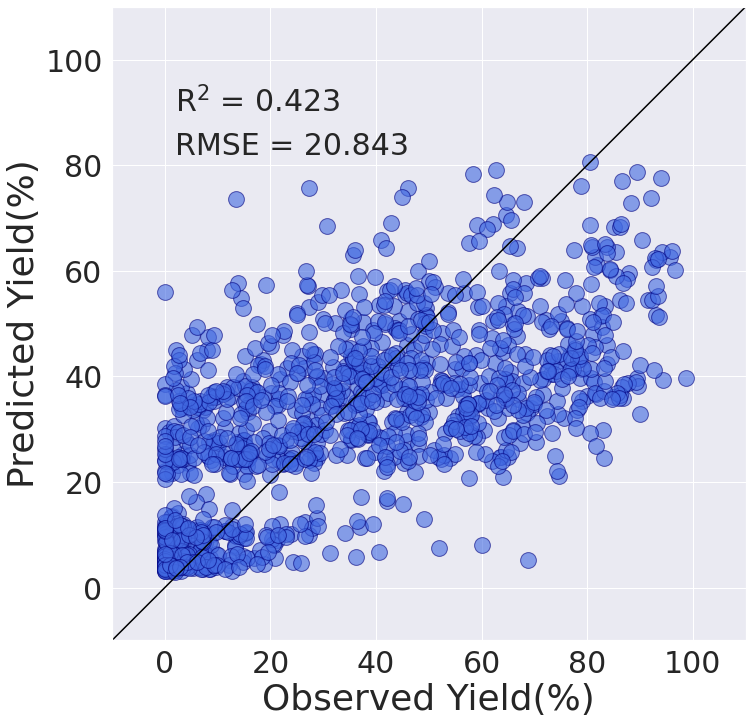

In [12]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',  
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)

plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [13]:
np.save( '../result/data1_Baseline_MG_GCN_y_val.npy',y_val)
np.save( '../result/data1_Baseline_MG_GCN_y_pred.npy',y_pred)